#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비
* 서버 주소 사용

In [7]:
mlflow_uri = "http://mini7-mlflow.carpediem.so/"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* 팀에서 1명만 새 실험 생성 
    * exp_## (## : 팀 번호)
    * 팀원들과 exp id 공유

In [ ]:
# exp_id = mlflow.create_experiment('experiment_18')
# exp_id
# '49'

## 2.데이터 준비

### (1) 데이터 분할1 : x, y 나누기

In [8]:
target = 'label'
x = data.drop(target, axis=1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, test

* 적절하게 분할 하시오.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000)

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [10]:
# 모두 넘파이로 변환
x_train, x_val, x_test, y_train, y_val, y_test = x_train.values, x_val.values, x_test.values, y_train.values, y_val.values, y_test.values

* shape 맞추기 n, 28,28,1

In [11]:
x_train = x_train.reshape(5000,28,28,1)
x_val = x_val.reshape(2000,28,28,1)
x_test = x_test.reshape(1000,28,28,1)

In [12]:
x_train.shape, x_val.shape, x_test.shape
# y_train.shape, y_val.shape, y_test.shape

((5000, 28, 28, 1), (2000, 28, 28, 1), (1000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [13]:
x_train_s = x_train / 255.
x_val_s = x_val / 255.
x_test_s = x_test / 255.

## 3.모델링
* 개인별 모델링 및 추적

### (1) 모델 추적

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.callbacks import Callback
from keras.optimizers import Adam

import mlflow.keras

In [26]:
with mlflow.start_run(experiment_id='49', run_name= 'a031253'):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="Sign_Signal_18")
    
    # autolog 종료
    mlflow.keras.autolog(disable = True)

Epoch 1/10
125/125 [==============================] - 4s 23ms/step - loss: 5.9788 - val_loss: 0.8285
Epoch 2/10
125/125 [==============================] - 3s 23ms/step - loss: 0.4434 - val_loss: 0.2866
Epoch 3/10
125/125 [==============================] - 3s 23ms/step - loss: 0.1315 - val_loss: 0.1681
Epoch 4/10
125/125 [==============================] - 3s 20ms/step - loss: 0.0563 - val_loss: 0.0725
Epoch 5/10
125/125 [==============================] - 2s 20ms/step - loss: 0.0243 - val_loss: 0.0526
Epoch 6/10
125/125 [==============================] - 2s 19ms/step - loss: 0.0097 - val_loss: 0.0433
Epoch 7/10
125/125 [==============================] - 3s 20ms/step - loss: 0.0048 - val_loss: 0.0334
Epoch 8/10
125/125 [==============================] - 3s 22ms/step - loss: 0.0034 - val_loss: 0.0346
Epoch 9/10
125/125 [==============================] - 3s 22ms/step - loss: 0.0033 - val_loss: 0.0271
Epoch 10/10
1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy8iu80pd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy8iu80pd\model\data\model\assets
2023/05/18 17:05:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp2r0b3pvr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp2r0b3pvr\model\data\model\assets
Registered model 'Sign_Signal_18' already exists. Creating a new version of this model...
2023/05/18 17:05:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal_18, version 11
Created version '11' of model 'Sign_Signal_18'.


* 학습곡선

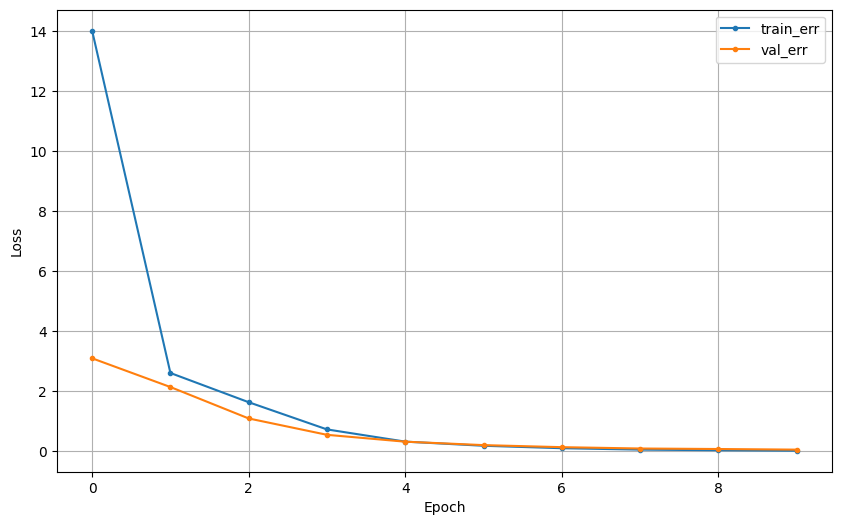

In [21]:
dl_history_plot(history)

* 예측 및 검증

In [22]:
pred = model.predict(x_val)

63/63 [==============================] - 0s 4ms/step


In [23]:
pred_1 = pred.argmax(axis=1)

In [24]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))

0.9865
------------------------------------------------------------
[[ 88   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  65   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  78   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  63   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   0]
 [  0   0   0   0   0  85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  83   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  86   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0  87   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  93

In [25]:
print(classification_report(class_names[y_val], class_names[pred_1]))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        88
           b       1.00      1.00      1.00        65
           c       1.00      1.00      1.00        67
           d       1.00      1.00      1.00        78
           e       1.00      0.95      0.98        66
           f       0.99      1.00      0.99        85
           g       0.95      1.00      0.98        83
           h       0.99      1.00      0.99        86
           i       1.00      0.99      0.99        88
           k       1.00      0.96      0.98        97
           l       0.97      1.00      0.99       101
           m       1.00      0.99      0.99       100
           n       0.99      1.00      0.99        85
           o       1.00      1.00      1.00        83
           p       1.00      1.00      1.00        65
           q       1.00      1.00      1.00        95
           r       0.98      0.92      0.95        91
           s       0.96    

## 4.모델 사용하기
* 팀에서 1명만 mlflow server ui에 접속하여 
    * model_## 의 각 버전 중 성능이 가장 좋은 버전을 production으로 상태변경
* 팀원들은 각자 운영모델 로딩하고, 사용해보기
    * test 셋으로 예측 및 평가
    * test image 하나를 불러와서 예측

### (1) 운영모델 로딩

In [ ]:
model_uri = "models:/model_14/production" 
model_p = mlflow.keras.load_model(model_uri)

### (2) test 데이터로 예측하고 평가

In [ ]:
pred = model_p.predict(x_test)
pred_1 = pred.argmax(axis=1)

In [ ]:
print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

### (2) 이미지 로딩해서 사용하기
* 과제1 코드 참조

In [ ]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

In [ ]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

test_sign = test_sign / 255.

pred = model_p.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])